<a href="https://colab.research.google.com/github/oshodiS/AII/blob/main/project_train_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

# 0. Importing libraries

In [1]:
colab = True

In [2]:
%%capture
if colab:
  !pip install fitter
  !pip install pydot
  !pip install graphviz

In [3]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

if colab:
  from fitter import Fitter
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers
  import tensorflow_probability as tfp
  from tensorflow.keras import callbacks

# 1. Load and inspect the dataset

In [4]:
if colab:
    # se con colab
    from pathlib import Path

    from google.colab import drive

    drive.mount('/content/drive')
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
else:
    # se in locale
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

Mounted at /content/drive


,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [5]:
print(df.columns)

to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df_cleaned = df.drop(to_remove, axis=1, inplace=False)

df_cleaned.head()

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,1.221239,28.250000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,0.778761,28.250000
2,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.219018,33.469565
3,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,0.979995,33.469565
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.153287,33.469565


In [6]:
# Unique duration values
DURATION = df_cleaned['duration[h]'].unique()
print(DURATION)

[ 1  3  6 12 24]


## 1.1. Preprocess the dataset
spiegazione

In [7]:
# create a dictionary of dataframes, one for each duration
dfs = {}
for duration in DURATION:
    dfs[f'{duration}'] = df_cleaned[df_cleaned['duration[h]'] == duration].drop("duration[h]", axis=1, inplace=False)
    dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [8]:
dfs['3']

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.106796,51.500000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.893204,51.500000
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.184466,51.500000
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.815534,51.500000
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,245.328628,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,0.876011,53.195652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,0.946180,37.836364
54924,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,1.009611,37.836364
54925,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,0.459875,37.836364
54926,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,1.009611,37.836364


In [9]:
# maximum value of AMS in each dataframe
for duration in DURATION:
    print(f"maximum AMS in {duration}h: {dfs[f'{duration}']['AMS'].max()}")

maximum AMS in 1h: 4.782464297575557
maximum AMS in 3h: 4.905896003540713
maximum AMS in 6h: 5.373404747735238
maximum AMS in 12h: 5.915663202234329
maximum AMS in 24h: 6.288661312900612


### scale the columns of the df

In [10]:
def scale_AMS(df, k = 1, IdD = True):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to True.
    """
    if IdD:
        df['AMS'] = df.apply(lambda row: row['AMS'] * row['IdD'], axis=1)

    min_AMS = df['AMS'].min() - 1e-3
    max_AMS = df['AMS'].max() * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df

In [109]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

features_not_to_scale = ['ID', 'AMS', 'mean_IdD']
features_to_scale = dfs['1'].columns.drop(features_not_to_scale)

order_columns = ['ID', 'AMS', 'mean_IdD'] + list(features_to_scale)

scaler = MinMaxScaler()
std_dfs = {}

for duration in DURATION:
    scaled_data = scaler.fit_transform(dfs[f'{duration}'][features_to_scale])
    non_scaled_data = dfs[f'{duration}'][features_not_to_scale]
    std_dfs[f'{duration}'] = np.concatenate([non_scaled_data, scaled_data], axis=1)

    # convert to dataframe
    std_dfs[f'{duration}'] = pd.DataFrame(std_dfs[f'{duration}'], columns=order_columns)

    # scale AMS
    std_dfs[f'{duration}'] = scale_AMS(std_dfs[f'{duration}'], k=3, IdD = False) #NON C'era fattore moltiplicativo e c'era un ams = 1

In [110]:
std_dfs['1']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,0.085183,28.250000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,5001.0,0.054345,28.250000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,5002.0,0.085028,33.469565,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,...,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
3,5002.0,0.068370,33.469565,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,...,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
4,5002.0,0.080447,33.469565,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,...,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54930,21338.0,0.069633,29.054545,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54931,21338.0,0.050443,29.054545,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54932,21338.0,0.039889,29.054545,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54933,21338.0,0.066755,29.054545,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423


In [13]:
if colab:
    # colab
    dataset_path = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    #  locale
    dataset_path = "data/gumMap_statbench_Gumfit_NEW.csv"

df2 = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df2.head()

,Unnamed: 0,ID,Nome,md_1h,md_3h,md_6h,md_12h,md_24h,q1h_0.80,q1h_0.95,...,q_3h_0.99,q_6h_0.80,q_6h_0.95,q_6h_0.99,q_12h_0.80,q_12h_0.95,q_12h_0.99,q_24h_0.80,q_24h_0.95,q_24h_0.99
0,0,5005,'Anzola_Dellemilia',1.0,1.0,1.0,1.0,1.0,1.297268,1.770921,...,2.204652,1.262136,1.679814,2.142859,1.256130,1.664236,2.116671,1.257223,1.667072,2.121439
1,1,5007,'Argelato',1.0,1.0,1.0,1.0,1.0,1.307714,1.798013,...,2.270210,1.272879,1.707674,2.189696,1.264559,1.686097,2.153422,1.257970,1.669008,2.124694
2,2,5015,'Bardi_Centrale',1.0,1.0,1.0,1.0,1.0,1.271656,1.704500,...,2.174044,1.257236,1.667106,2.121495,1.251259,1.651604,2.095435,1.253316,1.656940,2.104405
3,3,5141,'Invaso',1.0,1.0,1.0,1.0,1.0,1.271679,1.704561,...,2.174045,1.257236,1.667106,2.121496,1.251259,1.651605,2.095436,1.253324,1.656960,2.104438
4,4,5143,'Isola_Di_Palanzano_Centrale',1.0,1.0,1.0,1.0,1.0,1.265930,1.689653,...,2.173967,1.257225,1.667077,2.121446,1.251233,1.651538,2.095324,1.250087,1.648565,2.090326


## 1.2. Train-Val-Test split

In [111]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df2['ID'].to_list()[:100]

test_dfs = {}
for duration in DURATION:
    test_dfs[f'{duration}'] = std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)]
    test_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [112]:
# Drop the test set from std_dfs and then create the train sets and validation sets
for duration in DURATION:
    std_dfs[f'{duration}'] = std_dfs[f'{duration}'].drop(std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)].index,)
    std_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

validation_split = 0.1

train_dfs = {}
val_dfs = {}
for duration in DURATION:
    train_dfs[f'{duration}'], val_dfs[f'{duration}'] = train_test_split(std_dfs[f'{duration}'], test_size=validation_split, shuffle=False)
    train_dfs[f'{duration}'].reset_index(drop=True, inplace=True)
    val_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [113]:
val_dfs['3']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,20034.0,0.049180,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
1,20034.0,0.056736,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
2,20034.0,0.047806,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
3,20034.0,0.049867,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
4,20034.0,0.085590,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,21338.0,0.063381,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5181,21338.0,0.067695,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5182,21338.0,0.030307,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5183,21338.0,0.067695,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423


## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

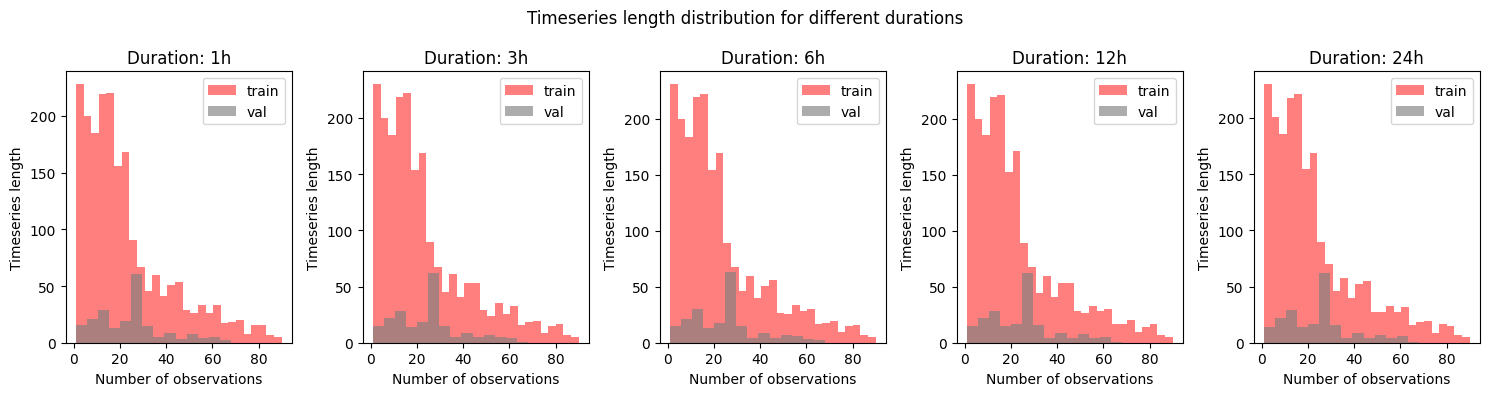

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns
fig.suptitle("Timeseries length distribution for different durations")

for i, duration in enumerate(DURATION):
    ax = axes[i]
    ax.hist(train_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.5, label='train', color='red')
    ax.hist(val_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.65, label='val', color='gray')
    ax.legend()
    ax.set_title(f"Duration: {duration}h")
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("Timeseries length")

plt.tight_layout()
plt.show()

### MAP distribution for training and validation

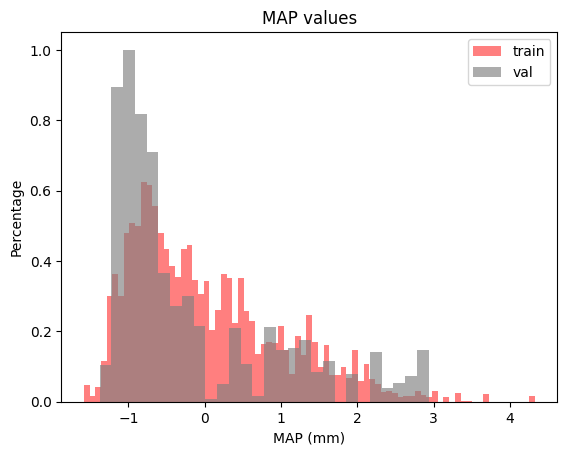

In [18]:
plt.hist(train_dfs['3']['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_dfs['3']['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()

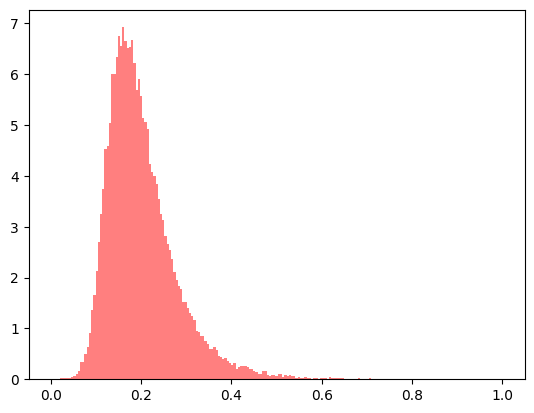

In [19]:
#create a global list of ams
#ams_global =  list(chain.from_iterable([train_dfs[duration]['AMS'] for duration in train_dfs]))

ams_3 = train_dfs['3']['AMS']

#plot the histogram
plt.hist(ams_3, bins='auto', alpha=0.5, label='train', density=True, color='red');

2024-01-29 19:45:22.654 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=9.876054)
2024-01-29 19:45:22.674 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=45.192028)
2024-01-29 19:45:22.690 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=345.214004)
2024-01-29 19:45:23.560 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=10.763044)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,9.876054,1104.441601,1130.693529,inf,0.042832,8.062810e-75
beta,10.763044,1180.804184,1215.806754,inf,0.045380,6.155047e-84
norm,45.192028,2420.247067,2437.748352,inf,0.092472,0.000000e+00
uniform,345.214004,3.959110,21.460395,inf,0.606170,0.000000e+00


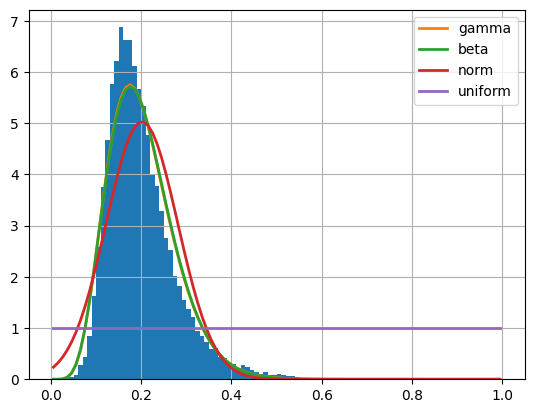

In [20]:
#Fit distribution
'''ams_global_np = np.array(ams_global)
f = Fitter(ams_global, distributions=['beta', 'gamma', 'norm', 'uniform'])'''
ams_1_np = np.array(ams_3)
f = Fitter(ams_3, distributions=['beta', 'gamma', 'norm', 'uniform'])
f.fit()
f.summary()

In [21]:
a_guess, b_guess, loc, scale  = f.fitted_param['beta']
print("alpha: ", a_guess)
print("beta: ", b_guess)

alpha:  7.254820357031425
beta:  175.98582887686695


## prepare data for training

In [114]:
print(train_dfs['3'].columns)

Index(['ID', 'AMS', 'mean_IdD', 'HMerit_mean(m)', 'HMerit_stdev(m)',
       'Slope_mean(deg)', 'Slope_stdev(deg)', 'Aspect_mean(deg)',
       'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)',
       'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)',
       'OrograTirr_mean(m)', 'OrograTirr_stdev(m)', 'OrograTirr_max(m)',
       'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [115]:
columns = train_dfs['1'].columns
input_columns = columns[3:]
output_column = 'AMS'
print('Input columns: ', input_columns)

Input columns:  Index(['HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [116]:
inputs_train = {}
outputs_train = {}
for duration in DURATION:
    inputs_train[f'{duration}'] = train_dfs[f'{duration}'][input_columns]
    outputs_train[f'{duration}'] = train_dfs[f'{duration}'][output_column]

inputs_val = {}
outputs_val = {}
for duration in DURATION:
    inputs_val[f'{duration}'] = val_dfs[f'{duration}'][input_columns]
    outputs_val[f'{duration}'] = val_dfs[f'{duration}'][output_column]

In [117]:
inputs_train['1']

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,0.342699,0.438339,0.428583,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,0.342699,0.438339,0.428583,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,0.273428,0.395750,0.340450,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
3,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,0.273428,0.395750,0.340450,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
4,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,0.273428,0.395750,0.340450,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46660,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,0.398465,0.663196,0.673132,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
46661,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,0.398465,0.663196,0.673132,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
46662,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,0.398465,0.663196,0.673132,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
46663,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,0.398465,0.663196,0.673132,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404


## alpha and beta guesses?

#### Base model + Train loop + loglikelohood loss



In [120]:
def build_nn_beta_model(input_shape, hidden, alpha_guess=1, beta_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)
    alpha_beta = layers.Dense(2, activation='linear')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0= tf.math.exp( t[:,0:1] ), concentration1=tf.math.exp(t[:,1:2] ), validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

In [131]:
# create a custom train loop to train the model and print alpha and beta values at each batch
def train_model(model, train_dataset, optimizer, epochs, batch_size, loss_fn):
    for epoch in range(epochs):
        print(f"\nStart of Training Epoch {epoch + 1}")

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_weights)

                try:
                  y_pred = model(x_batch_train, training=True)
                except:
                  print('ERRORE in ', step)
                  print('Trainable weights:')
                  print(model.trainable_weights)
                  print('^^^^^^^^^X, y^^^^^^^^^^^')
                  print(x_batch_train, y_batch_train)
                  print('LOSS: ', loss)
                #loss = -tf.reduce_mean(y_pred.log_prob(y_batch_train))
                loss = loss_fn(tf.cast(y_batch_train, tf.float32), y_pred)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        print('loss: ', np.mean(loss))

In [132]:
X_train = inputs_train['3'].values
y_train  = outputs_train['3'].values

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

epochs = 3
loss_fn = lambda y_true, dist: -dist.log_prob(y_true)
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
model = build_nn_beta_model(input_shape=(20,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)
train_model(model, train_dataset, optimizer, epochs, batch_size, loss_fn)


Start of Training Epoch 1
loss:  -2.0427933

Start of Training Epoch 2
loss:  -2.3552094

Start of Training Epoch 3
loss:  -2.5350533


#### Model with epsilon + train loop + negloglikelihood

In [137]:
def build_nn_beta_model_eps(input_shape, hidden, alpha_guess=1, beta_guess=1):
    epsilon = 1e-3  # Aggiungete una piccola costante, in modo che i due parametri non possano essere troppo vicini allo 0, e.g. f(x) = \eps + \exp(x)
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)
    alpha_beta = layers.Dense(2, activation='linear')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0= tf.math.exp( t[:,0:1] ) + epsilon, concentration1=tf.math.exp(t[:,1:2] ) + epsilon, validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

In [138]:
X_train = inputs_train['3'].values
y_train  = outputs_train['3'].values

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

epochs = 3
loss_fn = lambda y_true, dist: -dist.log_prob(y_true)
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
model = build_nn_beta_model_eps(input_shape=(20,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)
train_model(model, train_dataset, optimizer, epochs, batch_size, loss_fn)


Start of Training Epoch 1
loss:  -2.5082593

Start of Training Epoch 2
loss:  -2.455307

Start of Training Epoch 3
loss:  -2.480877


#### Base model + train loop + custom loss

In [98]:
def custom_loss(y_true, dist):
    # custom loss del tipo: -p(x) * log(p(x) + eps)

    # Get the log probability of the true values
    prob = dist.prob(y_true)

    if np.any(prob<=0):
      print('prob: ', prob, 'y_true:', y_true)


    # Add a small epsilon to the probability to avoid numerical instability
    epsilon = 1e-3
    regularized_prob = dist.prob(y_true) + epsilon


    # Calculate the negative log probability with epsilon regularization
    neg_log_prob_with_eps = -tf.math.log(regularized_prob)

    return - prob * neg_log_prob_with_eps

In [136]:
X_train = inputs_train['3'].values
y_train  = outputs_train['3'].values

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

epochs = 3
loss_fn = custom_loss
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
model = build_nn_beta_model(input_shape=(20,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)
train_model(model, train_dataset, optimizer, epochs, batch_size, loss_fn)


Start of Training Epoch 1
loss:  -0.3614625

Start of Training Epoch 2
loss:  -0.36566728

Start of Training Epoch 3
loss:  -0.36529386


#### Model with epsilon + train loop + custom loss

In [139]:
X_train = inputs_train['3'].values
y_train  = outputs_train['3'].values

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

epochs = 3
loss_fn = custom_loss
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
model = build_nn_beta_model_eps(input_shape=(20,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)
train_model(model, train_dataset, optimizer, epochs, batch_size, loss_fn)


Start of Training Epoch 1
loss:  -0.36486393

Start of Training Epoch 2
loss:  -0.36370587

Start of Training Epoch 3
loss:  -0.36440966
